# Neural Networks
In this notebook we will learn how to train a simple Multilayer Perceptron for image classification using PyTorch. You can find additional information [here](https://pytorch.org/tutorials/beginner/basics/intro.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Load dataset

In [2]:
# torchvision has some datasets already included, so we will load MNIST through torchvision
# first we need to define the transformations

data_aug = transforms.Compose([transforms.ToTensor()]) # the ToTensor transform scales the image into [0., 1.0] range
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)
indices = list(range(len(validation_data)))
np.random.shuffle(indices)

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

torch.Size([1, 28, 28])
5
torch.Size([64, 1, 28, 28])
tensor([0, 3, 6, 5, 6, 6, 1, 5, 5, 5, 8, 1, 2, 9, 6, 3, 0, 3, 0, 8, 4, 7, 2, 4,
        7, 2, 0, 2, 8, 8, 6, 1, 3, 0, 7, 9, 5, 2, 4, 3, 9, 4, 0, 8, 3, 0, 9, 2,
        5, 8, 7, 4, 7, 0, 1, 7, 9, 9, 9, 3, 7, 8, 0, 4])


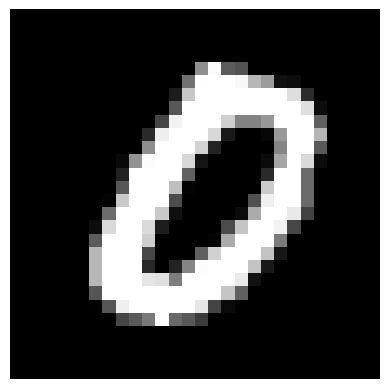

In [3]:
# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 64
num_workers = 2 # how many processes are used to load the data

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, sampler=val_sampler, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(validation_data, sampler=test_sampler, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

# let's visualize the data
# alternative 1: using the Dataset
sample = training_data[0] 
img = sample[0]
label = sample[1]
print(img.shape) # note that here we only get one image and its label
print(label)

# alternative 2: iterate over the Dataloader
for batch in train_dataloader:
  imgs = batch[0]
  labels = batch[1]
  print(imgs.shape)
  print(labels)

  plt.imshow(imgs[0][0,:,:], cmap='gray')
  plt.axis('off')
  plt.show()
  break

## Defining the model

Create an MLP with the following structure: 

1. Dense/linear layer that takes the images as a flattened input vector and generates an output of 512 of dimension.
2. ReLU activation layer
3. Dense/linear layer with 512 input and output
3. ReLU activation layer
4. Dense/linear layer with 10 output channels (10 classes of MNIST)

You can use PyTorch's layers: https://pytorch.org/docs/stable/nn.html (Conv2d, ReLU, Linear, MaxPool2d, Dropout, Flatten)

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device) # put model in device (GPU or CPU)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Interpret the implemented architecture and try to answer the following questions:

a) What is the shape (width, and # of channels) of the output tensor after the first layer?

b) And after the first 3 layers (dense+dense+dense)?

c) How many parameters (weights) does the model have? Contrary to Keras, PyTorch does not have an official method for counting the number of parameters of a model, but you can use [torchsummary](https://pypi.org/project/torch-summary/)

In [5]:
print("Equation: w*x + b, thus we have w * #_dimensions + #_bias")
print(f"1st Dense Layer: {784 * 512 + 512}")
print(f"2nd Dense Layer: {512 * 512 + 512}")
print(f"3rd Dense Layer: {512 * 10 + 10}")

Equation: w*x + b, thus we have w * #_dimensions + #_bias
1st Dense Layer: 401920
2nd Dense Layer: 262656
3rd Dense Layer: 5130


In [6]:
#!pip install torch-summary
from torchsummary import summary
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 512]                 401,920
|    └─ReLU: 2-2                         [-1, 512]                 --
|    └─Linear: 2-3                       [-1, 512]                 262,656
|    └─ReLU: 2-4                         [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 10]                  5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
Total mult-adds (M): 1.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.55
Estimated Total Size (MB): 2.57


Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 512]                 401,920
|    └─ReLU: 2-2                         [-1, 512]                 --
|    └─Linear: 2-3                       [-1, 512]                 262,656
|    └─ReLU: 2-4                         [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 10]                  5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
Total mult-adds (M): 1.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.55
Estimated Total Size (MB): 2.57

## Train the model

In [7]:
loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [9]:
num_epochs = 10
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")
    train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
    val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # save latest model
    save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)
    
print("Finished")

Start training...

Epoch 1


100%|██████████| 937/937 [00:11<00:00, 83.89it/s] 


Train loss: 2.279 	 Train acc: 0.286


100%|██████████| 125/125 [00:01<00:00, 84.07it/s]


Val loss: 2.253 	 Val acc: 0.438

Epoch 2


100%|██████████| 937/937 [00:10<00:00, 89.39it/s] 


Train loss: 2.222 	 Train acc: 0.514


100%|██████████| 125/125 [00:01<00:00, 80.62it/s]


Val loss: 2.184 	 Val acc: 0.562

Epoch 3


100%|██████████| 937/937 [00:10<00:00, 90.12it/s] 


Train loss: 2.133 	 Train acc: 0.595


100%|██████████| 125/125 [00:01<00:00, 81.41it/s]


Val loss: 2.066 	 Val acc: 0.640

Epoch 4


100%|██████████| 937/937 [00:10<00:00, 90.38it/s]


Train loss: 1.978 	 Train acc: 0.661


100%|██████████| 125/125 [00:01<00:00, 81.08it/s] 


Val loss: 1.863 	 Val acc: 0.689

Epoch 5


100%|██████████| 937/937 [00:09<00:00, 95.61it/s] 


Train loss: 1.730 	 Train acc: 0.703


100%|██████████| 125/125 [00:01<00:00, 72.64it/s]


Val loss: 1.565 	 Val acc: 0.715

Epoch 6


100%|██████████| 937/937 [00:09<00:00, 96.91it/s] 


Train loss: 1.418 	 Train acc: 0.731


100%|██████████| 125/125 [00:01<00:00, 90.76it/s] 


Val loss: 1.249 	 Val acc: 0.753

Epoch 7


100%|██████████| 937/937 [00:09<00:00, 98.48it/s] 


Train loss: 1.138 	 Train acc: 0.768


100%|██████████| 125/125 [00:01<00:00, 89.12it/s] 


Val loss: 1.006 	 Val acc: 0.789

Epoch 8


100%|██████████| 937/937 [00:09<00:00, 96.95it/s] 


Train loss: 0.938 	 Train acc: 0.796


100%|██████████| 125/125 [00:01<00:00, 81.90it/s]


Val loss: 0.841 	 Val acc: 0.810

Epoch 9


100%|██████████| 937/937 [00:09<00:00, 99.39it/s] 


Train loss: 0.802 	 Train acc: 0.817


100%|██████████| 125/125 [00:01<00:00, 88.25it/s] 


Val loss: 0.729 	 Val acc: 0.828

Epoch 10


100%|██████████| 937/937 [00:09<00:00, 95.38it/s] 


Train loss: 0.708 	 Train acc: 0.831


100%|██████████| 125/125 [00:01<00:00, 88.02it/s] 

Val loss: 0.648 	 Val acc: 0.844
Finished


## Analyse training evolution

In [10]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

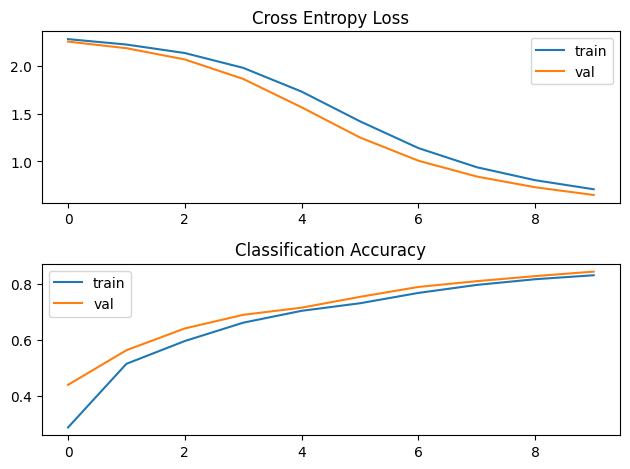

In [11]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set.

In [12]:
# load the best model (i.e. model with the lowest val loss...might not be the last model)
# we could also load the optimizer and resume training if needed

model = NeuralNetwork().to(device)
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model'])

test_loss, test_acc = epoch_iter(test_dataloader, model, loss_fn, is_train=False)
print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}")

100%|██████████| 2000/2000 [00:07<00:00, 285.51it/s]


Test Loss: 0.660 
Test Accuracy: 0.841


In [13]:
def showErrors(model, dataloader, num_examples=20):    
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= 20: break
      X, y = X.to(device), y.to(device)    
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
    plt.show()

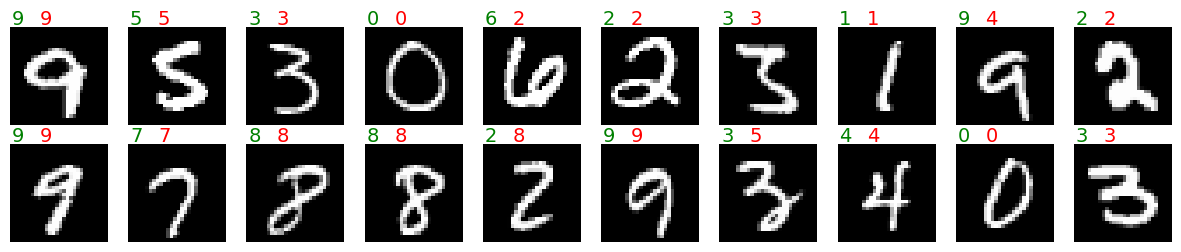

In [14]:
showErrors(model, test_dataloader)

## Additional Challenges

a) As the test accuracy should show, the MNIST dataset is not very challenging, change the code to use Fashion-MNIST and compare the results.

b) Do the same for the CIFAR10 (or CIFAR100) dataset. Note that, in this case, each image is a 32x32 color image; convert it to grayscale or concatenate the RGB channels in one single vector (e.g. using the reshape method).

c) The test accuracy for CIFAR is significantly worse. Try improving the results by using: 1) a deeper architecture, and 2) a different optmizer.

You can load the datasets from [here](https://pytorch.org/vision/stable/datasets.html).
